In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('questions.csv')

for col in df.columns:
    df[col] = df[col].replace(',', '', regex=True)
    df[col] = df[col].replace('$', '', regex=True)

df['Sr. No'] = df['Sr. No'].fillna(method='ffill')
df['Sr. No'] = df['Sr. No'].astype(int)
grouped_df = df.groupby('Sr. No')
required_columns = ['Data'] + [f'Unnamed: {i}' for i in range(3, 10)]
processed_groups = {}
for name, group in grouped_df:
    missing_columns = [
        col for col in required_columns if col not in group.columns]
    if missing_columns:
        print(f"Missing columns in group {name}: {missing_columns}")
        continue
    filtered_group = group[required_columns]
    filtered_group.fillna('', inplace=True)
    processed_groups[name] = filtered_group
df.drop(columns=required_columns, inplace=True)
new_df = df.groupby('Sr. No').first()

for i in range(1, len(processed_groups) + 1):
    d = processed_groups[i]
    new_columns = d.iloc[0]
    d.columns = new_columns
    d = d.drop(d.index[0])
    d.reset_index(drop=True, inplace=True)
    d.replace("", float("NaN"), inplace=True)
    d.dropna(how='all', axis=1, inplace=True)
    d = d.drop(d.index[-1])
    processed_groups[i] = d

new_df = new_df.assign(Data=processed_groups.values())
df = new_df
df.reset_index(drop=True, inplace=True)
df.head()

C:\Users\Aditya\AppData\Local\Temp\ipykernel_24700\1602288140.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Sr. No'] = df['Sr. No'].fillna(method='ffill')
C:\Users\Aditya\AppData\Local\Temp\ipykernel_24700\1602288140.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  filtered_group.fillna('', inplace=True)
C:\Users\Aditya\AppData\Local\Temp\ipykernel_24700\1602288140.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_group.fillna('', inplace=True)
C:\Users\Aditya\AppData\Local\Temp\ipykernel_24700\1602288140.py:22: FutureWarning:

,Questions,Alpha,Type,Data
0,A researcher is studying the effect of differe...,0.05,CRD,0 Fertilizer A Fertilizer B Fertilizer C 0 ...
1,A company wants to compare customer satisfacti...,0.01,CRD,7 Model X Model Y Model Z 0 7 8 ...
2,To study the effect of three different diets o...,0.05,CRD,14 Diet A Diet B Diet C 0 5 4 ...
3,The preference scores (out of 10) for three di...,0.05,FD,21 Market Packaging A Packaging B Packaging...
4,The productivity (in units) for employees usin...,0.05,FD,29 Shift Tool A Tool B Tool C 0 Day...


In [2]:
temp = df.iloc[3]['Data']
temp

21,Market,Packaging A,Packaging B,Packaging C
0,Market 1,8,7,9
1,Market 1,9,6,8
2,Market 1,7,8,9
3,Market 2,6,9,7
4,Market 2,8,7,6
5,Market 2,7,8,9


In [3]:
def isFirstColumnMergedHeader(df):
    firstColumn = df.to_numpy()
    firstColumn = firstColumn.T
    firstColumn = list(set(firstColumn[0]))
    firstColumn = [x for x in firstColumn if not pd.isna(x)]
    return len(firstColumn) == 1

isFirstColumnMergedHeader(temp)

False

In [4]:
def isSecondColumnGroupedHeader(df):
    column = df.to_numpy()
    column = column.T
    column = [x for x in column[1] if not pd.isna(x)]
    sample = list(set(column))
    countOfSample = [column.count(x) for x in sample]
    if len(set(countOfSample)) == 1 and countOfSample[0] > 1:
        return True
    else:
        if any(str(x).isalpha() for x in sample):
            return True
        else:
            return False


isSecondColumnGroupedHeader(temp)

False

In [5]:
def isFirstColumnHeader(df):
    if isFirstColumnMergedHeader(df):
        return True
    firstColumn = df.to_numpy()
    firstColumn = firstColumn.T[0]
    if any(str(n).isalpha() for n in firstColumn):
        return True
    elif all(str(n).isnumeric() for n in firstColumn):
        firstColumn = [int(x) for x in firstColumn]
        if firstColumn == list(range(firstColumn[0], firstColumn[-1] + 1)):
            return True
        else:
            return False
    else:
        for x in firstColumn:
            try:
                float(x)
            except ValueError:
                return True
        return False

isFirstColumnHeader(temp)

True

In [6]:
def isFirstColumnGroupedHeader(df):
    if isFirstColumnHeader(df):
        column = df.to_numpy()
        column = column.T[0]
        column = [x for x in column if not pd.isna(x)]
        sample, countOfSample = np.unique(column, return_counts=True)
        if all(x == countOfSample[0] for x in countOfSample) and countOfSample[
                0] > 1:
            return True
        else:
            return False
    else:
        return False


isFirstColumnGroupedHeader(temp)

True

In [7]:
def isFirstRowHeader(df, data):
    firstRow = df.iloc[0]
    firstRow = list(firstRow)
    firstRow = [x for x in firstRow if not pd.isna(x)]
    if isFirstColumnHeader(data):
        firstRow = firstRow[1:]
    if any(n.isalpha() for n in firstRow):
        return True
    elif all(n.isnumeric() for n in firstRow):
        num_list = [int(n) for n in firstRow]
        if num_list == list(range(num_list[0], num_list[0] + len(num_list))):
            return True
        else:
            return False
    else:
        if all(isinstance(x, (int, float)) for x in firstRow):
            if all(x.is_integer() for x in firstRow):
                return False
            else:
                return True
        else:
            return False

In [8]:
def extractData(df):
    data = []
    if isFirstColumnMergedHeader(df):
        if isSecondColumnGroupedHeader(df):
            data = df.iloc[:, 2:]
        else:
            data = df.iloc[:, 1:]
    elif isFirstColumnHeader(df):
        data = df.iloc[:, 1:]
    elif isFirstColumnGroupedHeader(df):
        data = df.iloc[:, 1:]
    else:
        data = df.iloc[:, :]

    if isFirstRowHeader(data, df):
        data = data[1:]
    data.reset_index(drop=True, inplace=True)
    data = data.to_numpy()
    for i in range(len(data)):
        for j in range(len(data[i])):
            try:
                data[i][j] = float(data[i][j])
            except:
                pass
    return data

extractData(temp)


array([[8.0, 7.0, 9.0],
       [9.0, 6.0, 8.0],
       [7.0, 8.0, 9.0],
       [6.0, 9.0, 7.0],
       [8.0, 7.0, 6.0],
       [7.0, 8.0, 9.0]], dtype=object)

In [9]:
df['isFirstColumnMergedHeader'] = df['Data'].apply(isFirstColumnMergedHeader)
df['isSecondColumnGroupedHeader'] = df['Data'].apply(isSecondColumnGroupedHeader)
df['isFirstColumnHeader'] = df['Data'].apply(isFirstColumnHeader)
df['isFirstColumnGroupedHeader'] = df['Data'].apply(isFirstColumnGroupedHeader)
df['isFirstRowHeader'] = df.apply(lambda x: isFirstRowHeader(x['Data'], x['Data']), axis=1)
df['Extracted Data'] = df['Data'].apply(extractData)

df.head()

,Questions,Alpha,Type,Data,isFirstColumnMergedHeader,isSecondColumnGroupedHeader,isFirstColumnHeader,isFirstColumnGroupedHeader,isFirstRowHeader,Extracted Data
0,A researcher is studying the effect of differe...,0.05,CRD,0 Fertilizer A Fertilizer B Fertilizer C 0 ...,False,False,False,False,False,"[[45.0, 50.0, 55.0], [48.0, 52.0, 53.0], [46.0..."
1,A company wants to compare customer satisfacti...,0.01,CRD,7 Model X Model Y Model Z 0 7 8 ...,False,False,False,False,False,"[[7.0, 8.0, 6.0], [6.0, 7.0, 7.0], [8.0, 9.0, ..."
2,To study the effect of three different diets o...,0.05,CRD,14 Diet A Diet B Diet C 0 5 4 ...,False,False,False,False,False,"[[5.0, 4.0, 6.0], [6.0, 5.0, 7.0], [4.0, 6.0, ..."
3,The preference scores (out of 10) for three di...,0.05,FD,21 Market Packaging A Packaging B Packaging...,False,False,True,True,False,"[[8.0, 7.0, 9.0], [9.0, 6.0, 8.0], [7.0, 8.0, ..."
4,The productivity (in units) for employees usin...,0.05,FD,29 Shift Tool A Tool B Tool C 0 Day...,False,False,True,True,False,"[[20.0, 18.0, 22.0], [21.0, 19.0, 23.0], [19.0..."


In [10]:
df.to_csv('output.csv', index=False)

In [11]:
import pandas as pd

df = pd.read_csv('output.csv')

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

features = ['isFirstColumnMergedHeader', 'isSecondColumnGroupedHeader',
            'isFirstColumnHeader', 'isFirstColumnGroupedHeader', 'isFirstRowHeader']
X = df[features]
y = df['Type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, predictions)}")

Logistic Regression Accuracy: 0.9523809523809523
Decision Tree Accuracy: 1.0
Random Forest Accuracy: 1.0
Support Vector Machine Accuracy: 0.9047619047619048


In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
combined = []
for name, model in models:
    print(model)
    scores = cross_val_score(model, X, y, cv=5)
    print(f"{model} Average Accuracy: {scores.mean()}")

ValueError: too many values to unpack (expected 2)

In [ ]:
# print confusion matrix for each model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = [
    'CRD',
    'RBD',
    'FD'
]

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks([0.5, 1.5, 2.5], labels)
    plt.yticks([0.5, 1.5, 2.5], labels)
    plt.show()

AttributeError: 'tuple' object has no attribute 'items'

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def format_y_axis(value, tick_number):
    return f'{value:.1f}'


formatter = FuncFormatter(format_y_axis)

data = []

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    report = classification_report(y_test, predictions, output_dict=True)
    print(f"{name} Classification Report")
    print(classification_report(y_test, predictions))
    for class_name, metrics in report.items():
        if class_name in ['accuracy', 'macro avg', 'weighted avg']:
            continue

        data.append({
            'Model': name,
            'Class': class_name,
            'Precision': metrics['precision'],
            'Recall': metrics['recall']
        })

df = pd.DataFrame(data)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

df.pivot(index='Model', columns='Class')[
    'Precision'].plot(kind='bar', ax=axs[0])
axs[0].set_ylabel('Precision')
axs[0].legend(loc='upper right')
axs[0].set_ylim([0.5, 1.0])
axs[0].yaxis.set_major_formatter(formatter)
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=0)

df.pivot(index='Model', columns='Class')['Recall'].plot(kind='bar', ax=axs[1])
axs[1].set_ylabel('Recall')
axs[1].legend(loc='upper right')
axs[1].set_ylim([0.5, 1.0])
axs[1].yaxis.set_major_formatter(formatter)
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

AttributeError: 'tuple' object has no attribute 'items'

c:\Users\Aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


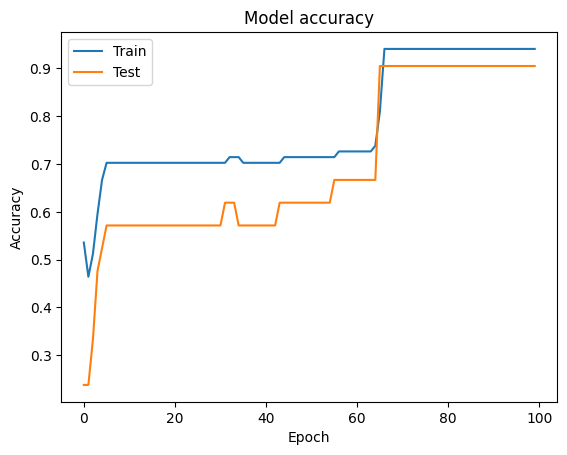

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Convert the labels to categorical
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Define the model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_categorical, validation_data=(
    X_test, y_test_categorical), epochs=100, verbose=0)

# Plot the training accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
import joblib

for name, model in models.items():
    joblib.dump(model, f"saves/{name}.pkl")

In [ ]:
sample_data = pd.read_csv('FDsamplequestion.csv')

sample_data

,Unnamed: 0,Unnamed: 1,Test Marks,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,NaN,NaN,A,B,C,D
1,Student,Aditya,10,12,11,14
2,NaN,NaN,9,3,6,12
3,NaN,Shivani,7,14,9,10
4,NaN,NaN,11,15,12,9


In [ ]:
characteristics = {
    "isFirstColumnMergedHeader": isFirstColumnMergedHeader(sample_data),
    "isSecondColumnGroupedHeader": isSecondColumnGroupedHeader(sample_data),
    "isFirstColumnHeader": isFirstColumnHeader(sample_data),
    "isFirstColumnGroupedHeader": isFirstColumnGroupedHeader(sample_data),
    "isFirstRowHeader": isFirstRowHeader(sample_data, sample_data),
}


print(characteristics)

{'isFirstColumnMergedHeader': True, 'isSecondColumnGroupedHeader': True, 'isFirstColumnHeader': True, 'isFirstColumnGroupedHeader': False, 'isFirstRowHeader': True}


In [ ]:
import os
models_path = "saves/"

models = {}

for file in os.listdir(models_path):
    if file.endswith(".pkl"):
        model = joblib.load(models_path + file)
        models[file[:-4]] = model

models


{'Decision Tree': DecisionTreeClassifier(),
 'Logistic Regression': LogisticRegression(),
 'Random Forest': RandomForestClassifier(),
 'Support Vector Machine': SVC()}

In [ ]:
predictions = {}
for name, model in models.items():
    predictions[name] = model.predict([list(characteristics.values())])[0]

predictions

c:\Users\Aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\Aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\Aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


{'Decision Tree': 'FD',
 'Logistic Regression': 'FD',
 'Random Forest': 'FD',
 'Support Vector Machine': 'FD'}

In [ ]:
# Category Total Cases Solved Cases Precision F1-Score
# GOF - Known Exp Known 3 3 1.00 1.00
# GOF - Uniform Distribution 5 5 1.00 1.00
# GOF - Poisson Distribution 4 4 1.00 1.00
# GOF - Normal Distribution 2 2 1.00 1.00
# GOF - Exp Percentage 1 0 0.00 0.00
# GOF - Uniform Text 2 2 1.00 1.00
# GOF - Percentage Text 2 0 0.00 0.00
# TFI - Calculated 11 11 1.00 1.00
# TFI - Text 2 2 1.00 1.00
# Weighted Average F1-Score 0.91

# convert this into a table

data = {
    'Category': ['CRD', 'RBD', 'FD'],
    'Total Cases': [26, 51, 26],
    'Precision': {
        'Random Forest': [1.00, 1.00, 1.00],
        'Decision Tree': [1.00, 1.00, 1.00],
        'Support Vector Machine': [1.00, 1.00, 1.00],
        'Logistic Regression': [1.00, 1.00, 1.00],
    },
    'F1-Score': {
        'Random Forest': [1.00, 1.00, 1.00],
        'Decision Tree': [1.00, 1.00, 1.00],
        'Support Vector Machine': [1.00, 1.00, 1.00],
        'Logistic Regression': [1.00, 1.00, 1.00],
    }
}

In [1]:
import pandas as pd

df = pd.read_csv('output.csv')

# print the count of each type
df['Type'].value_counts()

Type
RBD                  51
CRD                  26
FD                   26
Insufficient Data     2
Name: count, dtype: int64

In [2]:
data = {
    'Category': ['CRD', 'RBD', 'FD'],
    'Total Cases': [26, 51, 26],
    'Precision': {
        'Random Forest': [1.00, 1.00, 1.00],
        'Decision Tree': [1.00, 1.00, 1.00],
        'Support Vector Machine': [1.00, 1.00, 1.00],
        'Logistic Regression': [1.00, 1.00, 1.00],
    },
    'F1-Score': {
        'Random Forest': [1.00, 1.00, 1.00],
        'Decision Tree': [1.00, 1.00, 1.00],
        'Support Vector Machine': [1.00, 1.00, 1.00],
        'Logistic Regression': [1.00, 1.00, 1.00],
    }
}

# print this as a table, and also i want Precision and F1-Score to be a merged header
df = pd.DataFrame(data)
df

ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

In [6]:
import pandas as pd

data = {
    ('', 'Category'): ['CRD', 'RBD', 'FD'],
    ('', 'Total Cases'): [26, 51, 26],
    ('Precision', 'Random Forest'): [0.90, 0.92, 0.91],
    ('Precision', 'Decision Tree'): [0.91, 0.92, 0.93],
    ('Precision', 'Support Vector Machine'): [0.93, 0.94, 0.95],
    ('Precision', 'Logistic Regression'): [0.85, 0.86, 0.87],
    ('F1-Score', 'Random Forest'): [0.91, 0.92, 0.93],
    ('F1-Score', 'Decision Tree'): [0.92, 0.93, 0.94],
    ('F1-Score', 'Support Vector Machine'): [0.94, 0.95, 0.96],
    ('F1-Score', 'Logistic Regression'): [0.86, 0.87, 0.88],
}

df = pd.DataFrame(data)
df.columns = pd.MultiIndex.from_tuples(df.columns)
styles = [
    dict(selector="th", props=[("text-align", "center")]),
    dict(selector="td", props=[("text-align", "center")]),
]

df.style.set_table_styles(styles)
df

Precision                                       \
  Category Total Cases Random Forest Decision Tree Support Vector Machine   
0      CRD          26          0.90          0.91                   0.93   
1      RBD          51          0.92          0.92                   0.94   
2       FD          26          0.91          0.93                   0.95   

                           F1-Score                                       \
  Logistic Regression Random Forest Decision Tree Support Vector Machine   
0                0.85          0.91          0.92                   0.94   
1                0.86          0.92          0.93                   0.95   
2                0.87          0.93          0.94                   0.96   

                       
  Logistic Regression  
0                0.86  
1                0.87  
2                0.88

c:\Users\Aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


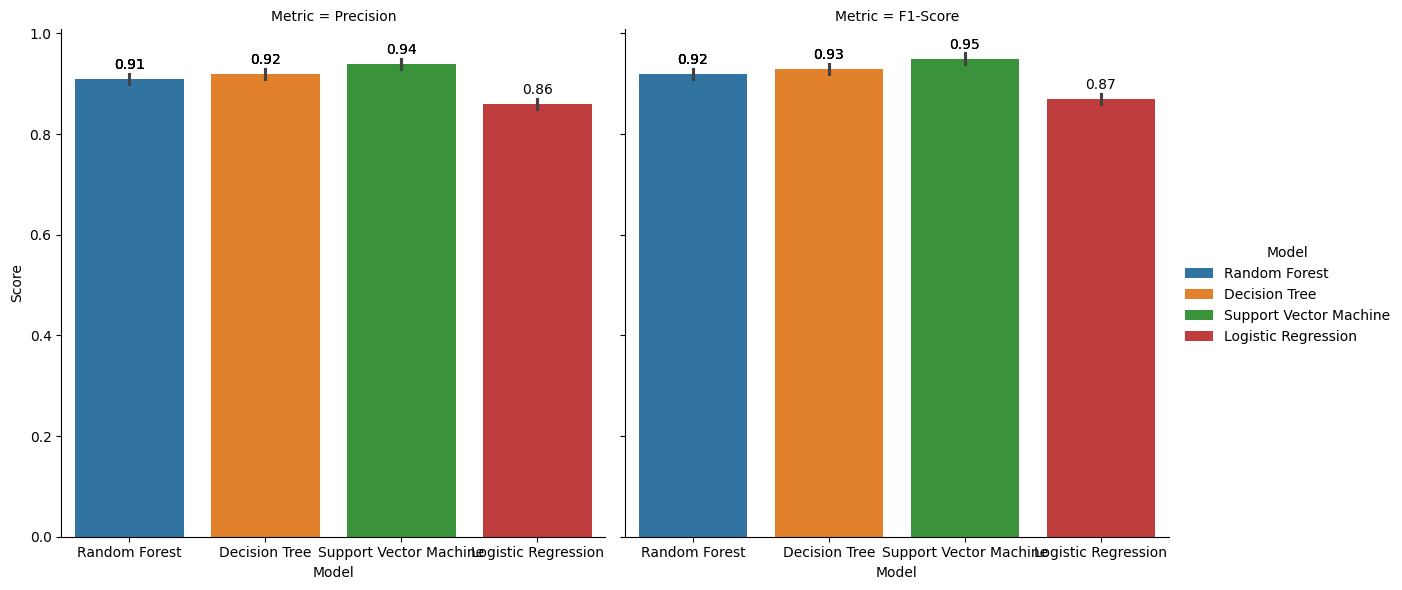

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape the DataFrame
df_melted = df.melt(id_vars=[('', 'Category'), ('', 'Total Cases')], var_name=[
                    'Metric', 'Model'], value_name='Score')

# Create a custom plotting function


def barplot(x, y, **kwargs):
    ax = sns.barplot(x=x, y=y, **kwargs)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points')


# Create a grid of plots
g = sns.FacetGrid(df_melted, col="Metric", hue="Model",
                  palette="tab10", height=6)
g.map(barplot, "Model", "Score", order=[
      'Random Forest', 'Decision Tree', 'Support Vector Machine', 'Logistic Regression'])

# Add a legend
g.add_legend()

# Show the plot
plt.show()